So,we start off by preparing the data. This means loading the data, and then performing augmentations and splitting it into training and testing data. To speed up learning times I will build off a pre existing model using transfer learning

In [73]:
import os
import copy
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from sklearn.utils import shuffle
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.font_manager
from collections import OrderedDict

In [74]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
print(os.getcwd())

/kaggle/working


This means we work on the GPU rather tha the CPU, which speeds up training significantly. 

In [75]:
input_path = "/kaggle/input/food-101/food-101/food-101/"
print(os.listdir(input_path))

['meta', 'README.txt', 'images', 'license_agreement.txt', '.DS_Store']


In [76]:
classes_path = os.path.join(input_path, "meta", "classes.txt")

# Read the first 20 classes and add an "other" class
classesread = open(classes_path, 'r').read().splitlines()
classes = classesread[:101]

print(classes)

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

The goal is to create a model that identifies your dish, and offers recommendations based off whether you liked it or not. To start with we train this model. 

In [77]:
def makedf(txt_path: str) -> pd.DataFrame:
    arr = open(txt_path, 'r').read().splitlines()
    img_base = os.path.join(input_path, "images")
    
    
    fullpath = [os.path.join(img_base, img + ".jpg") for img in arr]

   
    data = [img.split('/') for img in arr]
    data = np.array(data)

   
    df = pd.DataFrame({
        'label': data[:, 0],
        'image': data[:, 1],
        'path': fullpath
    })

    return shuffle(df)

In [78]:
input_path = "/kaggle/input/food-101/food-101/food-101/"
train_txt = os.path.join(input_path, "meta", "train.txt")
test_txt = os.path.join(input_path, "meta", "test.txt")

train_imgs = makedf(train_txt)
test_imgs = makedf(test_txt)

train_imgs.head(5)

,label,image,path
6533,bread_pudding,3484154,/kaggle/input/food-101/food-101/food-101/image...
67025,shrimp_and_grits,2318922,/kaggle/input/food-101/food-101/food-101/image...
52889,pad_thai,2645557,/kaggle/input/food-101/food-101/food-101/image...
69576,spring_rolls,3692777,/kaggle/input/food-101/food-101/food-101/image...
48428,miso_soup,2947825,/kaggle/input/food-101/food-101/food-101/image...


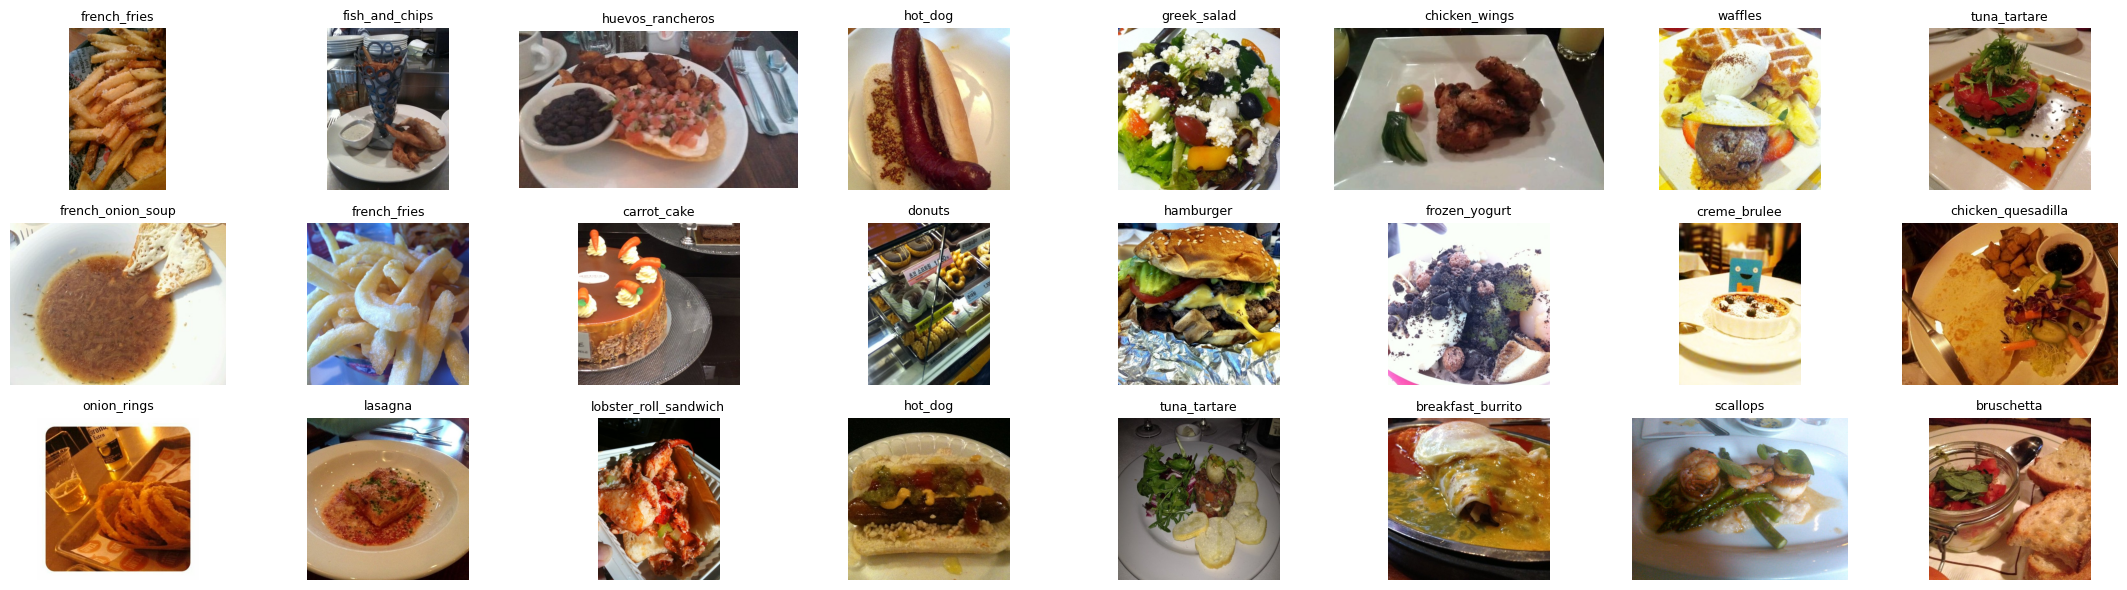

In [79]:
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 6))
rows, cols = 3, 8

for i in range(rows * cols):
    idx = np.random.randint(0, len(train_imgs))
    row = train_imgs.iloc[idx]
    
    image = plt.imread(row['path'])
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(image)
    ax.set_title(row['label'], fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [80]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),  
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

These transformations are done in order to make the model robust. As humans, we can identify a burger if it is sideways or not, so a model should be trained to do so too. Data should always be normalised or standardized before being fed into the model

In [81]:
class LabelEncoder:
    def __init__(self, labels):
        labels = sorted(list(set(labels))) 
        self.label2idx = {label: idx for idx, label in enumerate(labels)}
        self.idx2label = {idx: label for label, idx in self.label2idx.items()}

    def get_label(self, idx):
        return self.idx2label[idx]

    def get_idx(self, label):
        return self.label2idx[label]

encoder = LabelEncoder(classes)

for i in range(20):
    label = encoder.get_label(i)
    print(f"{label}: {encoder.get_idx(label)}")

apple_pie: 0
baby_back_ribs: 1
baklava: 2
beef_carpaccio: 3
beef_tartare: 4
beet_salad: 5
beignets: 6
bibimbap: 7
bread_pudding: 8
breakfast_burrito: 9
bruschetta: 10
caesar_salad: 11
cannoli: 12
caprese_salad: 13
carrot_cake: 14
ceviche: 15
cheese_plate: 16
cheesecake: 17
chicken_curry: 18
chicken_quesadilla: 19


In [82]:
from torch.utils.data import Dataset
from PIL import Image

class Food101Dataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe  
        self.transform = transform 

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['path']
        label_str = self.df.iloc[idx]['label']


        image = Image.open(img_path)
        if image.mode != 'RGB':
            image = image.convert('RGB')


        label = encoder.get_idx(label_str)


        if self.transform:
            image = self.transform(image)

        return image, label

In [83]:
train_dataset = Food101Dataset(train_imgs, transform=train_transforms)
test_dataset = Food101Dataset(test_imgs, transform=test_transforms)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)

When using neural networks, data gets fed in batches, in this case of size 64. 

In [84]:
for i in range(10):
    image_tensor, label_idx = train_dataset[i]
    label_name = encoder.get_label(label_idx)
    print(f"{i}: {label_name}, Image shape: {image_tensor.shape}")

0: bread_pudding, Image shape: torch.Size([3, 224, 224])
1: shrimp_and_grits, Image shape: torch.Size([3, 224, 224])
2: pad_thai, Image shape: torch.Size([3, 224, 224])
3: spring_rolls, Image shape: torch.Size([3, 224, 224])
4: miso_soup, Image shape: torch.Size([3, 224, 224])
5: cheese_plate, Image shape: torch.Size([3, 224, 224])
6: cannoli, Image shape: torch.Size([3, 224, 224])
7: caprese_salad, Image shape: torch.Size([3, 224, 224])
8: pizza, Image shape: torch.Size([3, 224, 224])
9: cheese_plate, Image shape: torch.Size([3, 224, 224])


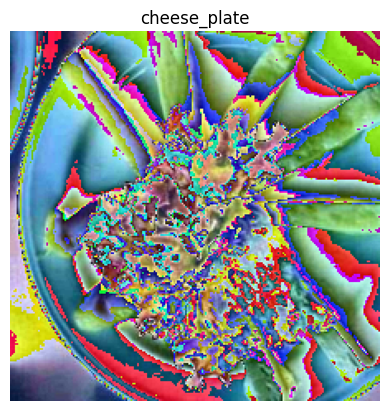

In [85]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


plt.imshow(F.to_pil_image(image_tensor))
plt.title(label_name)
plt.axis('off')
plt.show()

It looks odd as we have already applied augmentations and transformations to it. But this shows we have uploaded it correctly. 

In [86]:
weights = models.DenseNet121_Weights.IMAGENET1K_V1
model = models.densenet121(weights=weights)

Densenet is a pre trained image classification model. It has been chosen due to its speed, albeit at the cost of accuract. 

In [87]:
for param in model.parameters():
    param.requires_grad = False

In [88]:
for param in model.features.denseblock4.parameters():
    param.requires_grad = True

for param in model.classifier.parameters():
    param.requires_grad = True

In [89]:
model.classifier = nn.Linear(in_features=1024, out_features=101)
print(model.classifier) 

Linear(in_features=1024, out_features=101, bias=True)


The goal of this is to use transfer learning on these l

In [90]:
model.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [91]:
print(torch.cuda.is_available())  # Should print: True
print(torch.cuda.get_device_name(0)) 

True
Tesla T4


In [92]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
    return total_loss / len(dataloader.dataset)

In [93]:
def run_training(model, train_loader, optimizer, phase_name, start_epoch, num_epochs):
    for epoch in range(start_epoch, start_epoch + num_epochs):
        start_time = time.time()
        avg_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        epoch_time = time.time() - start_time
        eta = epoch_time * (start_epoch + num_epochs - epoch - 1)
        mins, secs = divmod(eta, 60)
        print(f"[{phase_name}] Epoch {epoch+1}/{start_epoch + num_epochs}, "
              f"Loss: {avg_loss:.4f}, "
              f"Epoch time: {epoch_time:.1f}s, ETA: {int(mins)}m {int(secs)}s")

In [94]:
import time

for param in model.parameters():
    param.requires_grad = False
for param in model.classifier.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
run_training(model, train_loader, optimizer, "Phase 1", start_epoch=0, num_epochs=3)


for param in model.features.denseblock4.parameters():
    param.requires_grad = True

params_to_optimize = filter(lambda p: p.requires_grad, model.parameters())
optimizer = torch.optim.Adam(params_to_optimize, lr=1e-4)
run_training(model, train_loader, optimizer, "Phase 2", start_epoch=3, num_epochs=13)

[Phase 1] Epoch 1/3, Loss: 2.3878, Epoch time: 296.0s, ETA: 9m 51s
[Phase 1] Epoch 2/3, Loss: 1.7000, Epoch time: 295.8s, ETA: 4m 55s
[Phase 1] Epoch 3/3, Loss: 1.5724, Epoch time: 295.6s, ETA: 0m 0s
[Phase 2] Epoch 4/16, Loss: 1.2456, Epoch time: 328.3s, ETA: 65m 40s
[Phase 2] Epoch 5/16, Loss: 0.9274, Epoch time: 327.4s, ETA: 60m 1s
[Phase 2] Epoch 6/16, Loss: 0.7444, Epoch time: 327.8s, ETA: 54m 38s
[Phase 2] Epoch 7/16, Loss: 0.5992, Epoch time: 327.6s, ETA: 49m 8s
[Phase 2] Epoch 8/16, Loss: 0.4775, Epoch time: 327.0s, ETA: 43m 36s
[Phase 2] Epoch 9/16, Loss: 0.3806, Epoch time: 326.9s, ETA: 38m 8s
[Phase 2] Epoch 10/16, Loss: 0.2976, Epoch time: 328.2s, ETA: 32m 49s
[Phase 2] Epoch 11/16, Loss: 0.2321, Epoch time: 327.5s, ETA: 27m 17s
[Phase 2] Epoch 12/16, Loss: 0.1827, Epoch time: 327.8s, ETA: 21m 51s
[Phase 2] Epoch 13/16, Loss: 0.1446, Epoch time: 327.5s, ETA: 16m 22s
[Phase 2] Epoch 14/16, Loss: 0.1171, Epoch time: 326.9s, ETA: 10m 53s
[Phase 2] Epoch 15/16, Loss: 0.0953, Ep

Our model initially trains for 3 epochs, with only the classifier head being unfrozen. This is done for efficiency, and to achieve a baseline loss. We then unfreeze the last dense block as well and train the model for 13 epochs to fine tune accuracy. 

In [95]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 75.54%


Note that this was a lightweight setup - there are more advanced models available, and I did not do too many epochs. This took an hour to do, with more hours it would probably be faster. 

In [96]:
torch.save(model.state_dict(), "food101_model.pth")

In [97]:
from IPython.display import FileLink
FileLink("food101_model.pth")

/kaggle/working/food101_model.pth

In [99]:
import joblib
joblib.dump(encoder, "label_encoder.pkl")
FileLink("label_encoder.pkl")

/kaggle/working/label_encoder.pkl